modified from Song's `hsc_um2` repo

In [20]:
from __future__ import division, print_function, unicode_literals

import time
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt

import emcee
print(emcee.__version__) #need version 3 (pip install emcee==3.0rc1)
import yaml

from scipy.stats import gaussian_kde

from astropy.table import Table, Column
from astropy.io import ascii, fits
from astropy.cosmology import FlatLambdaCDM

from halotools.sim_manager import TabularAsciiReader, HaloTableCache, CachedHaloCatalog
from halotools.sim_manager.rockstar_hlist_reader import RockstarHlistReader
from halotools.empirical_models import PrebuiltSubhaloModelFactory
from halotools.mock_observables import delta_sigma_from_precomputed_pairs, total_mass_enclosed_per_cylinder
from halotools.utils import randomly_downsample_data

3.0rc1


## parse config file 

In [46]:
def parse_config(config_file):
    """Prepare configurations.
    Read configuration parameters from an input .yaml file.
    """
    cfg = yaml.load(open(config_file))

    return cfg
config_initial = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/mcmc_default_config.yaml')
print(config_initial)

{'sim_halo_cat_file': 'hlist_0.78209.list', 'cosmos_h0': 0.7, 'param_ini': [0.6, 3.71, -0.01, 0.03, 0.57, -0.2, 0.05], 'sim_h0': 0.678, 'frac_objects_with_specz': 0.167685, 'mcmc_out_dir': '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/outfiles/', 'mcmc_moves_burnin': 'walk', 'param_upp': [1.1, 8.0, 0.05, 0.2, 1.0, 0.4, 0.5], 'mcmc_nwalkers_burnin': 128, 'mean_mass': 8.52695, 'sim_particle_mass': '1.5e8', 'cosmos_SMF_points_file': 'cosmos2015_dic2017_smf_z01-04_Vmax0_with_header.dat', 'mcmc_wl_only': False, 'cosmos_catalog_reference': 'Laigle+2016', 'sim_name': 'bolshoi-planck', 'cosmos_SMF_fit_file': 'cosmos2015_dic2017_smf_z01-04_STY0.dat', 'cosmos_dir': '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/', 'sim_z': 0.278625, 'sim_columns_to_keep_dict': "{'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'), 'halo_mvir': (10, 'f4'), 'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'), 'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'), 'halo_rvir': 

## define global variables for config and data files

In [23]:
def load_observed_data(cfg, verbose=True):
    """Load the observed data."""

    #SMF
    cosmos_SMF_fit_table = ascii.read(os.path.join(cfg['cosmos_dir'],
                                       cfg['cosmos_SMF_fit_file']))
    cosmos_SMF_points_table = ascii.read(os.path.join(cfg['cosmos_dir'],
                                       cfg['cosmos_SMF_points_file']))

#     cosmos_SMF_fit_m = cosmos_SMF_fit_table['log_m']
#     cosmos_SMF_fit_phi = cosmos_SMF_fit_table['log_phi']
#     cosmos_SMF_points_m = cosmos_SMF_points_table['logM']
#     cosmos_SMF_points_phi = cosmos_SMF_points_table['Phi']       

    #weak lensing
    cosmos_lensing_table = ascii.read(os.path.join(cfg['cosmos_dir'], cfg['cosmos_wl_file']))
    
    cosmos_wl_r = cosmos_lensing_table['R(Mpc)']
    cosmos_wl_ds = cosmos_lensing_table['SigR(Msun/pc^2)']
    
    #cosmology
    cfg['cosmos_cosmo'] = FlatLambdaCDM(H0=cfg['cosmos_h0'] * 100,
                                     Om0=cfg['cosmos_omega_m'])
    
#     obs_volume = ((cfg['obs_cosmo'].comoving_volume(obs_zmax) -
#                    cfg['obs_cosmo'].comoving_volume(obs_zmin)) *
#                   (cfg['obs_area'] / 41254.0)).value
#     cfg['obs_volume'] = obs_volume

    return {'cosmos_wl_r': cosmos_wl_r, 'cosmos_wl_ds': cosmos_wl_ds, 'cosmos_wl_table': cosmos_lensing_table,
            'cosmos_SMF_fit_table': cosmos_SMF_fit_table, 'cosmos_SMF_points_table': cosmos_SMF_points_table}, cfg

def load_sim_data(cfg):
    """Load the UniverseMachine data."""
    
    
    #read in halocat    
    halocat = CachedHaloCatalog(simname = cfg['sim_name'], halo_finder = cfg['sim_halo_finder'], 
                            version_name = cfg['sim_version_name'], redshift = cfg['sim_z'], ptcl_version_name=cfg['sim_ptcl_version_name']) # doctest: +SKIP


    
    #other parameters
    cfg['sim_cosmo'] = FlatLambdaCDM(H0=cfg['sim_h0'] * 100.0,
                                    Om0=cfg['sim_omega_m'])

    cfg['sim_volume'] = np.power(cfg['sim_lbox'] / cfg['sim_h0'], 3)
#     if verbose:
#         print("# The volume of the UniverseMachine mock is %15.2f Mpc^3" %
#               cfg['um_volume'])
        
#     return {'um_mock': um_mock_use[mask_mass],
#             'um_mass_encl': um_mass_encl[mask_mass, :],
#             'mask_central': mask_central[mask_mass]}

    return halocat, cfg

In [6]:
def setup_model(cfg, verbose=True):
    """Configure MCMC run and plots."""
    
    if cfg['model_type'] == 'model':
        # Number of parameters
        cfg['mcmc_ndims'] = 7
        cfg['mcmc_labels'] = [r'$a$',
                              r'$b$',
                              r'$c$',
                              r'$d$',
                              r'$f_{\mathrm{ins}}$',
                              r'$A_{\mathrm{exs}}$',
                              r'$B_{\mathrm{exs}}$']


#     # Degree of freedom for the model: This is actually WRONG
#     cfg['model_dof'] = (cfg['obs_smf_n_data'] + cfg['obs_dsigma_n_data'] -
#                         cfg['mcmc_ndims'])
    # --------------------------------------------------- #

    
    cfg['mcmc_burnin_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_burnin.npz')
    cfg['mcmc_run_file'] = os.path.join(
        cfg['mcmc_out_dir'], cfg['mcmc_prefix'] + '_run.npz')


    return cfg


In [47]:
def initial_model(config, verbose=True):
    """Initialize the A.S.A.P model."""
    # Configuration for COSMOS data
    data_obs, config_obs = load_observed_data(config, verbose=verbose)

    # Configuration for simulation data.
    data_sim, config_obs_sim = load_sim_data(config_obs)

    #setup model
    config_all = setup_model(config_obs_sim, verbose=verbose)

    return config_all, data_obs, data_sim

global config, cosmos_data, sim_data

# Load the data
config, cosmos_data, sim_data = initial_model(config_initial)

## setup model

In [38]:
def compute_SMF(model, config, nbins=100):
    
    #Read stellar masses
    M = model.mock.galaxy_table['stellar_mass'] 
    
    #Take logarithm
    logM = np.log10(M)                     

    #Survey volume in Mpc3
    L=config['sim_lbox']
    h0=config['sim_h0']
    V = (L/h0)**3                    
    
    #Unnormalized histogram and bin edges
    Phi,edg = np.histogram(logM,bins=nbins) 
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    bin_centers   = edg[0:-1] + dM/2.
    
    #Normalize to volume and bin size
    Phi   = Phi / float(V) / dM             
    logPhi= np.log10(Phi)
    
    return bin_centers, logPhi

def compute_deltaSigma(ptcl_table, model, config):
    
    #read in particle data
    px = ptcl_table['x']
    py = ptcl_table['y']
    pz = ptcl_table['z']
    particles = np.vstack((px, py, pz)).T
    
    #downsample 
    num_ptcls_to_use = int(1e4)
    particles = randomly_downsample_data(particles, num_ptcls_to_use)
    particle_masses = np.zeros(num_ptcls_to_use) + sim_data.particle_mass
    downsampling_factor = (config['sim_particles_per_dimension']**3)/float(len(particles))
    
    #select subsample of dwarfs from galaxy catalog
    galaxies_table=model.mock.galaxy_table[np.log10(model.mock.galaxy_table['stellar_mass'])>11]
    
    #read in galaxy positions
    x = galaxies_table['x']
    y = galaxies_table['y']
    z = galaxies_table['z']
    galaxies = np.vstack((x, y, z)).T
    
    #mass enclosed by cylinders around each galaxy
    period=model.mock.Lbox
    r_bins=[float(r) for r in config['sim_wl_bins'].split()]
    print(r_bins)
    
    mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor,
                                                 r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins, period, cosmology=config['sim_cosmo'])
    ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2
    
    return rp, ds


def predict_model(param, config, obs_data, sim_data,
                       constant_bin=False, return_all=False,
                       show_smf=False, show_dsigma=False):
    """Return all model predictions.
    Parameters
    ----------
    param: list, array, or tuple.
        Input model parameters.
    config : dict
        Configurations of the data and model.
    obs_data: dict
        Dictionary for observed data.
    sim_data: dict
        Dictionary for UniverseMachine data.
    constant_bin : boolen
        Whether to use constant bin size for logMs_tot or not.
    return_all : bool, optional
        Return all model information.
    show_smf : bool, optional
        Show the comparison of SMF.
    show_dsigma : bool, optional
        Show the comparisons of WL.
    """
    
    #build_model
    model = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
    #poluate mock catalog
    model.populate_mock(sim_data)

    # Predict SMFs
    smf_mass_bins, smf_log_phi = compute_SMF(model,config, nbins=100)

    # Predict DeltaSigma profiles
    ptcl_table = Table.read(os.path.join(config['sim_dir'], config['sim_particle_file']), path='data')
    wl_r, wl_ds = compute_deltaSigma(ptcl_table, model, config)
    

#     if show_smf:
#         um_smf_tot_all = get_smf_bootstrap(logms_mod_tot_all,
#                                            cfg['um_volume'],
#                                            20, cfg['obs_min_mtot'], 12.5,
#                                            n_boots=1)
#         _ = plot_mtot_minn_smf(
#             obs_data['obs_smf_tot'], obs_data['obs_smf_inn'],
#             obs_data['obs_mtot'], obs_data['obs_minn'],
#             um_smf_tot, um_smf_inn,
#             logms_mod_tot, logms_mod_inn,
#             obs_smf_full=obs_data['obs_smf_full'],
#             um_smf_tot_all=um_smf_tot_all,
#             not_table=True)

#     if show_dsigma:
#         um_mhalo_tuple = asap_predict_mhalo(
#             obs_data['obs_wl_dsigma'], um_data['um_mock'][mask_mtot],
#             logms_mod_tot, logms_mod_inn)
#         _ = plot_dsigma_profiles(obs_data['obs_wl_dsigma'],
#                                  um_dsigma_profs, obs_mhalo=None,
#                                  um_mhalo=um_mhalo_tuple)



    return smf_mass_bins, smf_log_phi, wl_r, wl_ds

In [39]:
parameters = list(config['param_ini'])
print(parameters)
# Generate the model predictions
sim_smf_mass_bins, sim_smf_log_phi, sim_wl_r, sim_wl_ds = predict_model(parameters, config, cosmos_data, sim_data)       

[0.6, 3.71, -0.01, 0.03, 0.57, -0.2, 0.05]
[0.01, 0.01598922, 0.02947921, 0.05184152, 0.09251636, 0.1643359, 0.29233885, 0.51980176, 0.92438561]


## plotting functions

In [50]:
def plot_SMF(sim_mass_centers, sim_logPhi, cosmos_SMF_points_table, cosmos_SMF_fit_table):
    
    #plot sim
    plt.plot(sim_mass_centers, sim_logPhi, c='r', label='Bolshoi-Planck halos')
    
    #plot COSMOS
    plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
    plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                     cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
    plt.errorbar(cosmos_SMF_points_table['logM'], cosmos_SMF_points_table['Phi'], 
                 yerr=[cosmos_SMF_points_table['Phi_err+'],cosmos_SMF_points_table['Phi_err-']], fmt='o', elinewidth=3,
                markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

    #plot details
    plt.xlabel('log(M)')
    plt.ylabel('log(Phi)')
    plt.xlim([8,12.5])
    plt.ylim([-10,0])
    plt.legend(loc='lower left')
    
    plt.show()
    
def plot_deltaSigma(observed_signal_table, sim_r, sim_ds):

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    plt.loglog()

    #plot sim
    ax.plot(sim_r, sim_ds, label=r'Bol-Planck: ', linestyle='--', zorder=3, marker='o')
    ax.fill_between(sim_r, sim_ds,sim_ds, alpha=0.5)

    #plot observations
    ax.errorbar(observed_signal_table['R(Mpc)'], observed_signal_table['SigR(Msun/pc^2)'],
                yerr=observed_signal_table['err(weights)'], marker='o', label=r'Laigle+2016: ', linewidth=3, zorder=1)
    # ax.fill_between(cosmos_lensing_signal['R(Mpc)'], cosmos_lensing_signal['SigR(Msun/pc^2)']+cosmos_lensing_signal['err(weights)'],
    #                 cosmos_lensing_signal['SigR(Msun/pc^2)']-cosmos_lensing_signal['err(weights)'], alpha=0.5)

    __=ax.set_xlim(xmin = 0.01, xmax = 1)
    # __=ax.set_ylim(ymin = 0.5, ymax = 200)

    __=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
    __=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
    __=ax.legend(loc='best', fontsize=13)
    __=plt.xticks(fontsize=15); plt.yticks(fontsize=15)

    #plt.title('Matched Mass distribution')
    plt.show()

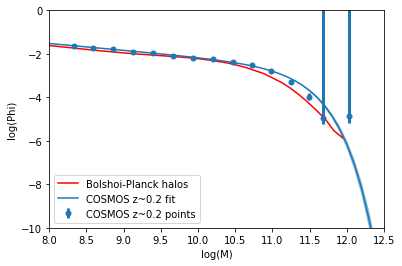

In [51]:
plot_SMF(sim_smf_mass_bins, sim_smf_log_phi, cosmos_data['cosmos_SMF_points_table'],
         cosmos_data['cosmos_SMF_fit_table'])

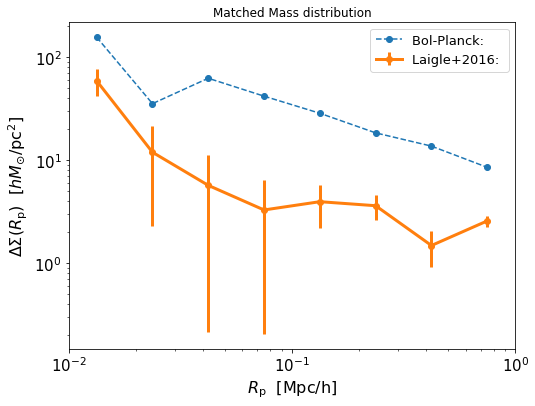

In [42]:
plot_deltaSigma(cosmos_data['cosmos_wl_table'], sim_wl_r, sim_wl_ds)

## probability functions

In [45]:
cosmos_data

{u'cosmos_SMF_fit_table': <Table length=300>
   log_m      log_phi   log_phi_inf log_phi_sup
  float64     float64     float64     float64  
 ---------- ----------- ----------- -----------
        0.0   0.9907256   1.0965684   0.8843038
        0.1   0.9593335   1.0640014   0.8540923
        0.2   0.9279413   1.0314345   0.8238808
        0.3   0.8965492   0.9988675   0.7936693
        0.4    0.865157   0.9663005   0.7634578
        0.5   0.8337649   0.9337335   0.7332463
        0.6   0.8023727   0.9011666   0.7030348
        0.7   0.7709806   0.8685996   0.6728233
        0.8   0.7395884   0.8360326   0.6426118
        0.9   0.7081963   0.8034657   0.6124003
        ...         ...         ...         ...
 29.0000004 999.9000244 999.9000244 999.9000244
 29.1000004 999.9000244 999.9000244 999.9000244
 29.2000004 999.9000244 999.9000244 999.9000244
 29.3000004 999.9000244 999.9000244 999.9000244
 29.4000004 999.9000244 999.9000244 999.9000244
 29.5000004 999.9000244 999.9000244 999.900

In [43]:
def flat_prior(param_tuple, param_low, param_upp):
    """Priors of parameters. Return -inf if all parameters are not within bounds."""
    if not np.all([low <= param <= upp for param, low, upp in
                   zip(list(param_tuple), param_low, param_upp)]):
        return -np.inf

    return 0.0

def ln_like(param_tuple, config, obs_data, sim_data, chi2=False,
                 sep_return=False):
    """Calculate the lnLikelihood of the model."""
    # Unpack the input parameters
    parameters = list(param_tuple)

    # Generate the model predictions
#     (sim_smf_tot, sim_smf_inn, sim_dsigma_profs) = predict_model(
#             parameters, cfg, obs_data, sim_data) 
    sim_smf_mass_bins, sim_smf_log_phi, sim_wl_r, sim_wl_ds = predict_model(parameters, config, obs_data, sim_data)   

    # Likelihood for SMFs.
    smf_lnlike = smf_lnlike(obs_data['cosmos_SMF_fit_table'], obs_data['cosmos_SMF_points_table'],
        sim_smf_mass_bins, sim_smf_log_phi)

    # Likelihood for DeltaSigma
    dsigma_lnlike = dsigma_lnlike(obs_data['cosmos_wl_table'], sim_wl_r, sim_wl_ds)

    if not np.isfinite(dsigma_lnlike):
        return -np.inf

    return smf_lnlike + cfg['mcmc_wl_weight'] * dsigma_lnlike

def smf_lnlike(obs_smf_fit_table, obs_smf_points_table, sim_smf_mass_bins, sim_smf_log_phi):
    """Calculate the likelihood for SMF."""
    
    #make sure same bins
    assert obs_smf_points_table['logM'] == sim_smf_mass_bins
    
    smf_dif = (np.array(sim_smf_log_phi) - np.array(obs_smf_tot['Phi']))

    smf_var = np.array(obs_smf_tot['Phi_err+'] ** 2)

    smf_chi2 = (smf_mtot_dif ** 2 / smf_mtot_var).sum()

    smf_lnlike = -0.5 * (smf_chi2 + np.log(2 * np.pi * smf_var).sum())


    # print("SMF Tot lnlike/chi2: %f,%f" % (smf_mtot_lnlike,
    #                                       smf_mtot_chi2))


    return smf_lnlike

def dsigma_lnlike(obs_wl_table, sim_wl_r, sim_wl_ds):
    """Calculate the likelihood for WL profile."""
    
    #make sure same bins
    assert obs_wl_table['R(Mpc)'] == sim_wl_r
    
    dsigma_obs = obs_wl_table['SigR(Msun/pc^2)']  
    dsigma_obs_err = obs_wl_table['err(weights)']

    dsigma_var = (dsigma_obs_err ** 2)
    dsigma_diff = (dsigma_obs - sim_wl_ds) ** 2

    dsigma_chi2 = (dsigma_diff / dsigma_var).sum()
    dsigma_lnlike = -0.5 * (dsigma_chi2 + np.log(2 * np.pi * dsigma_var).sum())
    # print("DSigma likelihood / chi2: %f, %f" % (dsigma_lnlike, dsigma_chi2))

    return dsigma_lnlike

def ln_prob_global(param_tuple):
    """Probability function to sample in an MCMC.

    Parameters
    ----------
    param_tuple: tuple of model parameters.

    """
    lp = flat_prior(param_tuple, config['param_low'], config['param_upp'])

    if not np.isfinite(lp):
        return -np.inf

    return lp + ln_like(param_tuple, config, obs_data, sim_data)

## setup mcmc functions 

In [ ]:
def mcmc_initial_guess(param_initial, param_sigma, n_walkers, n_dims):
    """Initialize guesses for the MCMC run. One guess for each dimension (model parameter) per walker,
    with a small sigma deviation from param_initial. """
    mcmc_position = np.zeros([n_walkers, n_dims])

    for ii, param_0 in enumerate(param_initial):
        mcmc_position[:, ii] = (
            param_0 + param_sigma[ii] * np.random.randn(n_walkers))

    return mcmc_position

def mcmc_setup_moves(config, move_col):
    """Choose the Move object for emcee."""
    if config[move_col] == 'snooker':
        emcee_moves = emcee.moves.DESnookerMove()
    elif config[move_col] == 'stretch':
        emcee_moves = emcee.moves.StretchMove(a=config['mcmc_stretch_a'])
    elif config[move_col] == 'walk':
        emcee_moves = emcee.moves.WalkMove(s=config['mcmc_walk_s'])
    elif config[move_col] == 'kde':
        emcee_moves = emcee.moves.KDEMove()
    elif config[move_col] == 'de':
        emcee_moves = emcee.moves.DEMove(config['mcmc_de_sigma'])
    else:
        raise Exception("Wrong option: stretch, walk, kde, de, snooker")
    
    return emcee_moves

def mcmc_burnin(mcmc_sampler, mcmc_position, config, verbose=True):
    """Run the MCMC chain."""
    # Burn-in
    if verbose:
        print("# Phase: Burn-in ...")
    mcmc_burnin_result = mcmc_sampler.run_mcmc(
        mcmc_position, config['mcmc_nburnin'],
        progress=True)

    mcmc_save_results(mcmc_burnin_result, mcmc_sampler,
                      config['mcmc_burnin_file'], config['mcmc_ndims'],
                      verbose=True)

    # Rest the chains
    mcmc_sampler.reset()

## run fit

In [12]:
#skip paralleization for now
def emcee_fit(config, verbose=True):
    # Initialize the model
    mcmc_ini_position = mcmc_initial_guess(
        config['param_ini'], config['param_sig'], config['mcmc_nwalkers'],
        config['mcmc_ndims'])

    # define the ensemble moves object for walkers during burn in
    burnin_move = mcmc_setup_moves(config, 'mcmc_moves_burnin')
    # define sampler
    burnin_sampler = emcee.EnsembleSampler(
        config['mcmc_nwalkers_burnin'],
        config['mcmc_ndims'],
        ln_prob_global,
        moves=burnin_move) #,pool=pool)

    # Burn-in
    mcmc_burnin_pos, mcmc_burnin_lnp, mcmc_burnin_state = emcee_burnin(
        burnin_sampler, mcmc_ini_position, config, verbose=True)

    # Estimate the Kernel density distributions of final burn-in positions
    # Resample the distributions to get starting positions of the actual run
    mcmc_kde = gaussian_kde(np.transpose(mcmc_burnin_pos), 
                        bw_method='silverman')
    mcmc_new_pos = np.transpose(mcmc_kde.resample(config['mcmc_nwalkers']))

    mcmc_new_ini = (mcmc_new_pos, mcmc_burnin_lnp, mcmc_burnin_state)

    
    # MCMC run
    
    # Decide the Ensemble moves for walkers during burnin
    emcee_move = mcmc_setup_moves(config, 'mcmc_moves')
    # define sampler
    mcmc_sampler = emcee.EnsembleSampler(config['mcmc_nwalkers'],
                                         config['mcmc_ndims'],
                                         ln_prob_global,
                                         moves=emcee_move)

    mcmc_run_result = emcee_run(mcmc_sampler, mcmc_new_ini, config, verbose=True)

    return mcmc_run_result

In [15]:
emcee_fit(config_initial)

# Phase: Burn-in ...
emcee: Exception while calling your likelihood function:
  params: [ 0.60988287  3.47401753 -0.03886581  0.01789452  0.79411887  0.15731723]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/emcee/ensemble.py", line 488, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-10-f5604446ad1c>", line 100, in ln_prob_global
    return lp + ln_like(param_tuple, config, obs_data, um_data)
NameError: global name 'obs_data' is not defined


NameError: global name 'obs_data' is not defined